In [ ]:
##import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
from glob import glob
import matplotlib.pyplot as plt
import random
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.model_selection import train_test_split
from IPython.display import Image
from keras.applications import Xception
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
print(tf.__version__)


2.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
BASE_DIR=('gdrive/My Drive/chest_xray/')
train_dir=os.path.join(BASE_DIR,'train/')
val_dir=os.path.join(BASE_DIR,'val/')
test_dir=os.path.join(BASE_DIR,'test/')

print('Number of images in training set = ',str(len(glob(train_dir+'*/*'))))
print('Number of images in validation set = ',str(len(glob(val_dir+'*/*'))))
print('Number of images in testing set = ',str(len(glob(test_dir+'*/*'))))

Number of images in training set =  4335
Number of images in validation set =  782
Number of images in testing set =  782


In [ ]:
model_builder = keras.applications.xception.Xception
model = model_builder(weights="imagenet")

91889664/91884032 [==============================] - 0s 0us/step


In [ ]:
for layers in model.layers:
    layers.trainable=False

In [ ]:
last_layer=model.get_layer('block14_sepconv2_act')
last_output = last_layer.output
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(last_output)
x=tf.keras.layers.Dense(1,activation='sigmoid', name = "predictions")(x)
model=tf.keras.Model(model.input,x)

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
               metrics=['accuracy','Precision','Recall'])

In [ ]:
train_datagen=ImageDataGenerator(rescale=1.0/255,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 zoom_range=0.2,
                                 #preprocessing_function=gray_to_rgb
                                 )

In [ ]:
val_datagen=ImageDataGenerator(rescale=1.0/255)

test_datagen=ImageDataGenerator(rescale=1.0/255)

train_generator=train_datagen.flow_from_directory(train_dir,target_size=(299,299),batch_size=128,class_mode='binary')

val_generator=val_datagen.flow_from_directory(val_dir,target_size=(299,299),batch_size=128,class_mode='binary')

test_generator=test_datagen.flow_from_directory(test_dir,color_mode="grayscale",target_size=(299,299),batch_size=128,class_mode='binary')

Found 4335 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 782 images belonging to 2 classes.


In [ ]:
history=model.fit(train_generator,epochs=5,verbose=2)

Epoch 1/5
34/34 - 1295s - loss: 0.4029 - accuracy: 0.8157 - precision: 0.8318 - recall: 0.9352
Epoch 2/5
34/34 - 601s - loss: 0.2902 - accuracy: 0.8819 - precision: 0.9040 - recall: 0.9368
Epoch 3/5
34/34 - 600s - loss: 0.2533 - accuracy: 0.8962 - precision: 0.9148 - recall: 0.9450
Epoch 4/5
34/34 - 602s - loss: 0.2362 - accuracy: 0.9017 - precision: 0.9269 - recall: 0.9387
Epoch 5/5
34/34 - 601s - loss: 0.2213 - accuracy: 0.9110 - precision: 0.9318 - recall: 0.9466


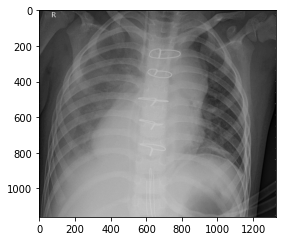

In [ ]:
model_builder = model
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input

last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]

# The local path to our target image
img_path = keras.utils.get_file(
    "pneumonia_1.jpeg", "https://i.imgur.com/YCGfMk9.jpg"
)
#
#https://i.imgur.com/qBUbu9K.jpg
#https://i.imgur.com/NDp3n28.jpg
#https://i.imgur.com/YCGfMk9.jpg

#display(Image(img_path))
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

no_cols=10
no_rows=10

pic_index=0
fig=plt.gcf()
fig.set_size_inches(no_cols*5,no_rows*5)

sp=plt.subplot(no_rows,no_cols,1)
sp.axis()
img=mpimg.imread(img_path)
plt.imshow(img,cmap='gray')
    
plt.show()

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


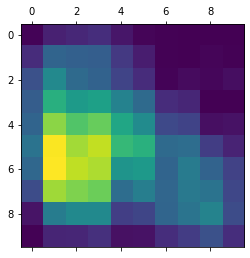

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model

# Print what the top predicted class is
preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

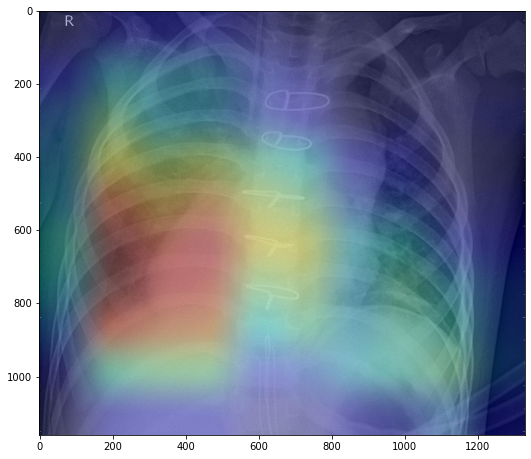

In [ ]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "pneumonia.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
#display(Image(save_path))
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

no_cols=4
no_rows=4

pic_index=0
fig=plt.gcf()
fig.set_size_inches(no_cols*10,no_rows*10)

sp=plt.subplot(no_rows,no_cols,1)
sp.axis()
img=mpimg.imread(save_path)
plt.imshow(img,cmap='gray')
    
plt.show()